In [484]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import shap
import warnings
import optuna
warnings.filterwarnings("ignore")
from sklearn.utils.class_weight import compute_sample_weight

In [516]:
dfr = pd.read_csv('./data/winequality-red.csv', sep=';')
target = 'quality'

### Splitting target and features

In [517]:
X = dfr.drop(columns=[target])
y = dfr[target]

### Splitting to train and test - We split 75% to train, and we stratify to balance the minority classes in the training and test set

In [518]:
def split_data_set(X, y):
    return train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = split_data_set(X,y)

### This function will help us understand if we improved after each step

In [519]:
def calculate_scores(y_true, y_pred, image_name = None):
    report = classification_report(
    y_true, y_pred, target_names=['3', '4', '5', '6', '7', '8'], output_dict=True
    )

    df_report = pd.DataFrame(report).transpose()

    df_report = df_report.drop(columns=['support'], errors='ignore')

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df_report.iloc[:-1, :].astype(float),
        annot=True, cmap="YlGnBu", cbar=True, fmt=".2f", linewidths=0.5,
    )

    plt.title('Figure 8: Classification Report', fontsize=16, weight='bold')
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Classes', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()

    if image_name:
        plt.savefig(f'./images/{image_name}', dpi=300, bbox_inches='tight')

## And this function to comapre 2 different results:

In [520]:
def compare_scores(path_result_1, path_result_2, headline_1, headline_2):
    first_pipeline_results = mpimg.imread(path_result_1)
    second_pipeline_results = mpimg.imread(path_result_2)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].imshow(first_pipeline_results)
    axes[0].axis('off')  # Hide the axes
    axes[0].set_title(headline_1)

    # Display the second image
    axes[1].imshow(second_pipeline_results)
    axes[1].axis('off')  # Hide the axes
    axes[1].set_title(headline_2)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

### And this one will help us identigy where the errors occurs.

In [521]:

def show_errors(y_true, y_pred):
    jitter = np.random.normal(0, 0.05, size=len(y_true))

    sns.set_theme(style="white")  # Removes the grid
    # Create figure and axis
    plt.figure(figsize=(8, 5))
    # Plot the y = x line
    sns.lineplot(x=[min(y_true), max(y_true)], y=[min(y_true), max(y_true)], color='black', label="y = x (Perfect Prediction)")
    # Scatter plot of true vs predicted values
    sns.scatterplot(x=y_true, y=y_pred + jitter)

    # Labels and title
    plt.xlabel("True Class (y_true)", fontsize=12)
    plt.ylabel("Predicted Class (y_pred)", fontsize=12)
    plt.title("Classification Predictions vs. True Labels", fontsize=14)
    plt.legend()
    plt.show()

# Basic Pipeline:

In [522]:
def round_results(y_pred):
    #To get the actual qualitys
    y_pred_rounded = np.array([])
    for pred in y_pred:
        y_pred_rounded = np.append(y_pred_rounded, round(pred))

    y_pred_indexed = pd.Series(y_pred_rounded, y_test.index)

    return y_pred_indexed

In [523]:
def get_predications(model, X_train_samples, X_test_samples, y_train_classes, sample_weights=None):
    model.fit(X_train_samples, y_train_classes, sample_weight=sample_weights)
    y_pred = model.predict(X_test_samples)
    return round_results(y_pred=y_pred)


In [527]:
basic_model = XGBRegressor(random_state=42)
y_pred_basic = get_predications(basic_model, X_train_samples=X_train, X_test_samples=X_test,y_train_classes=y_train)

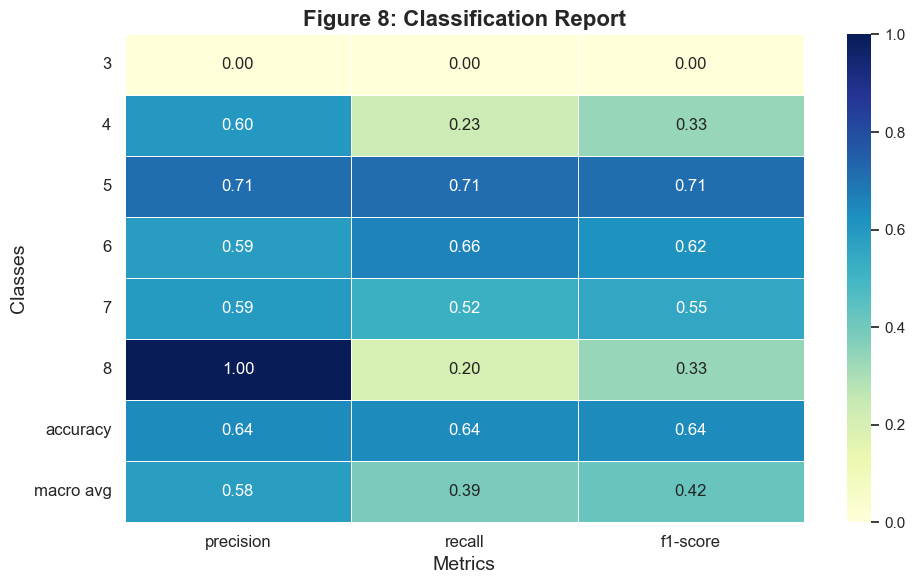

In [529]:
calculate_scores(y_test, y_pred_basic, 'basic-pipline-results')

 Key Takeaways from the Classification Report
## Class Performance:
- **Class 3:**
  - Poor performance with all metrics (`precision`, `recall`, and `f1-score`) being **0**.
  - The model failed to correctly classify any instances of this class.

- **Class 4:**
  - Struggles with low `precision` (**0.50**), `recall` (**0.23**), and `f1-score` (**0.32**).
  - Indicates difficulty in identifying this class correctly.

- **Class 5:**
  - Fairly balanced performance with `precision` (**0.70**), `recall` (**0.69**), and `f1-score` (**0.70**).
  - Shows reasonable performance for this class.

- **Class 6:**
  - Slightly better `recall` (**0.71**) but a moderate `f1-score` (**0.66**).
  - Indicates some imbalance in predictions.

- **Class 7:**
  - Moderate results with `precision` (**0.63**) but lower `recall` (**0.48**), leading to an `f1-score` of **0.55**.

- **Class 8:**
  - Perfect `precision` (**1.00**) but poor `recall` (**0.20**), resulting in a low `f1-score` (**0.33**).
  - Suggests overconfidence with very few true positives.

## Aggregate Metrics:
- **Accuracy:**
  - The overall accuracy is **0.65**, meaning roughly two-thirds of predictions were correct.

- **Macro Average:**
  - `Precision` (**0.57**), `recall` (**0.39**), and `f1-score` (**0.42**) reflect significant disparity in class-wise performance.

## Areas for Improvement:
- Significant attention is needed for **Class 3** and **Class 4**, as their metrics are substantially low.
- **Class 8** demonstrates overconfidence with high `precision` but very low `recall`, suggesting missed true positives.
- Balancing class-wise performance is critical, as shown by the discrepancy between the macro averages and overall accuracy.

## Balanced Classes:
- **Class 5** and **Class 6** exhibit the most balanced performance among the classes, indicating better predictability.

By addressing the weaknesses in specific classes, the overall performance of the classification model can be improved.


To do:
we should first balance the data and then do feature engineering

# Feature Engineering:

### Alcohol * Density

Based on the formula for density, the alcohol content in terms of mass can be calculated by multiplying the alcohol percentage by volume with the corresponding density. This calculation introduces a new feature, named alcohol_density, which may provide additional insights into the dataset.

In [530]:
X['alcohol density'] = X['alcohol'] * X['density']

## Total Acidity

Acidity, determined by the total sum of acids in a sample, is a key indicator of wine balance during winemaking. It is quantified as the sum of `fixed_acidity`, `volatile_acidity`, and `citric_acid`:

- **`fixed_acidity`**: Low-volatility organic acids like malic, lactic, tartaric, and citric acids, inherent to the sample's characteristics.
- **`volatile_acidity`**: Short-chain organic acids (e.g., formic, acetic, propionic, butyric acids) extractable via distillation.


In [531]:
X['total acidity'] = X['volatile acidity'] + X['fixed acidity'] + X['citric acid']

# experimenting with this feature
X['percent acidity'] = (X['volatile acidity'] / (X['fixed acidity']) + X['citric acid'])
print('Correlation with the target feature:')
print('total acidity', np.corrcoef(X['total acidity'], y)[0][1])
print('percent acidity', np.corrcoef(X['percent acidity'], y)[0][1])
print('volatile acidity', np.corrcoef(X['volatile acidity'], y)[0][1])
print('fixed acidity', np.corrcoef(X['fixed acidity'], y)[0][1])
print('citric acid', np.corrcoef(X['citric acid'], y)[0][1])

Correlation with the target feature:
total acidity 0.10375372825598383
percent acidity 0.19546266788359332
volatile acidity -0.39055778026400684
fixed acidity 0.1240516491132243
citric acid 0.2263725143180414


## Ideal ph Level

According to this [source](https://morewinemaking.com/articles/testing_wine_must), the ideal ph level for red wine should be around the 3.4 to 3.6 range. A `pH` above 3.6 indicates and unstable wine and will not have a long shelf life. pH under 3.4 generally indicates a wine that will be too sour. This may serve as a relevant indicator of what differentiated a good from a bad red wine.

In [532]:
X['ideal ph'] = 0
X.loc[(X['pH'] >= 3.4) & (X['pH'] <= 3.65), 'ideal ph'] = 1
print('Correlation with the target feature:')
print('ideal ph', np.corrcoef(X['ideal ph'], y)[0][1])
print('pH', np.corrcoef(X['pH'], y)[0][1])

Correlation with the target feature:
ideal ph -0.04809480006463261
pH -0.05773139120538216


## Acidity * ph

In [533]:
X['ph acidity'] = X['pH'] * X['percent acidity']
print('Correlation with the target feature:')
print('ph acidity', np.corrcoef(X['ph acidity'], y)[0][1])
print('pH', np.corrcoef(X['pH'], y)[0][1])
print('percent acidity', np.corrcoef(X['percent acidity'], y)[0][1])

Correlation with the target feature:
ph acidity 0.19678899392992685
pH -0.05773139120538216
percent acidity 0.19546266788359332


## Percent Free SO2

`sulfur_dioxide` is used in winemaking as a preservative to prevent oxidation and microbial spoilage. It exists in three forms; bisulfite (HSO3-), molecular SO2, and sulfite (SO32). The equilibrium is pH dependent with the predominate form at wine pH being bisulfite. Most of the rest is molecular and very little, if any, remains in sulfite form. These forms make up what is termed as `free_sulfur_dioxide`. `free_sulfur_dioxide` can be lost through volatilization or binding, thus management is important.


In [534]:
X['percent free sulfur'] = X['free sulfur dioxide'] / X['total sulfur dioxide']
print('Correlation with the target feature:')
print('percent free sulfur', np.corrcoef(X['percent free sulfur'], y)[0][1])
print('total sulfur dioxide', np.corrcoef(X['total sulfur dioxide'], y)[0][1])
print('free sulfur dioxide', np.corrcoef(X['free sulfur dioxide'], y)[0][1])

Correlation with the target feature:
percent free sulfur 0.1941133507473079
total sulfur dioxide -0.18510028892653774
free sulfur dioxide -0.05065605724427627


## Checking Feature Engenering Efficiency:
Let's apply this to our X_train and X_test samples and check weather it helped improve the result or not:

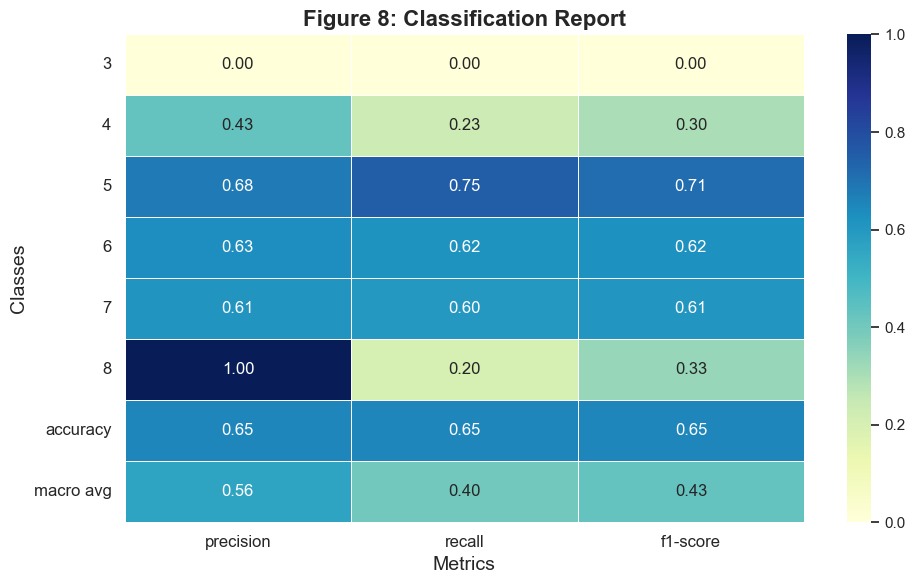

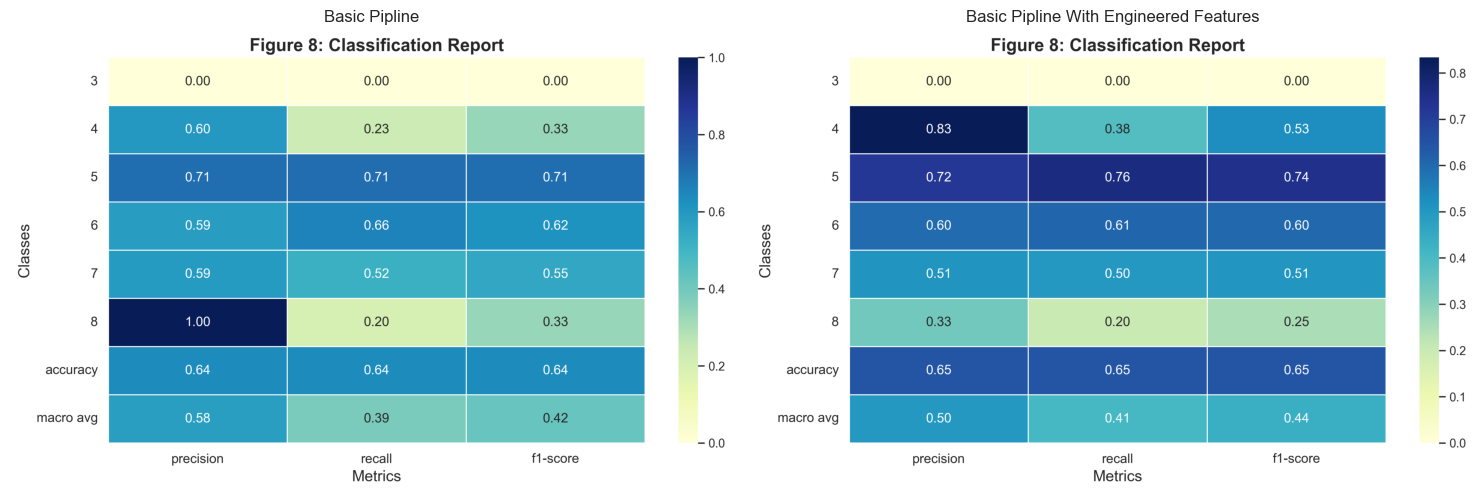

In [535]:
X_train, X_test, y_train, y_test = split_data_set(X,y)
y_pred_fe = get_predications(basic_model, X_train_samples=X_train, X_test_samples=X_test, y_train_classes=y_train)
calculate_scores(y_test, y_pred_fe, image_name='basic-pipline-with-feature-engineering-results')
compare_scores(path_result_1='./images/basic-pipline-results.png',
               path_result_2='./images/feature_engineering-pipline-results.png',
                headline_1='Basic Pipline',
                headline_2='Basic Pipline With Engineered Features')

###to do: put this plot next to the previous

## To do: add insights about the comprasion

## Balancing the data:

We have imbalanced data, we have a lot of classes for wines rated at 5-6, small amount of samples for wines rated 4 & 7, and almost no samples for wines rated at 3 & 8, we clearly saw this from the classification results table above. To fix this, we will use SMOTE and balance our classes. But, to keep our model from overfitting, we use a sampling strategy where we sample only the minority classes, and the overall samples will still be less then the common classes

In [541]:
sm = SMOTE(random_state=42, sampling_strategy='auto')
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [542]:

def show_balanced_data(y_train, y_res):
    # 1️⃣ Create a DataFrame for Seaborn
    df_before = pd.DataFrame({"Quality": y_train, "Dataset": "Before Balance"})
    df_after = pd.DataFrame({"Quality": y_res, "Dataset": "After Balance"})

    # Combine both datasets
    df_combined = pd.concat([df_before, df_after])

    # 2️⃣ Plot Histograms Using Seaborn
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_combined, x="Quality", hue="Dataset", multiple="layer", bins=6, kde=False, palette=["blue", "green"])

    # 3️⃣ Customize Plot
    plt.xlabel("Wine Quality Score")
    plt.ylabel("Count")
    plt.title("Class Distribution Before & After SMOTE")

    # 4️⃣ Show Plot
    plt.show()

### PLot the new syntetic data

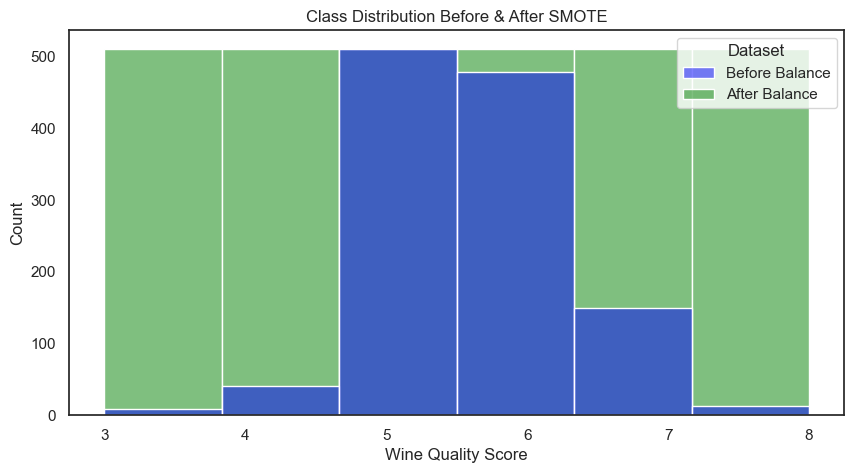

In [543]:
show_balanced_data(y_train=y_train, y_res=y_smote)

### Test results again with this balanced data

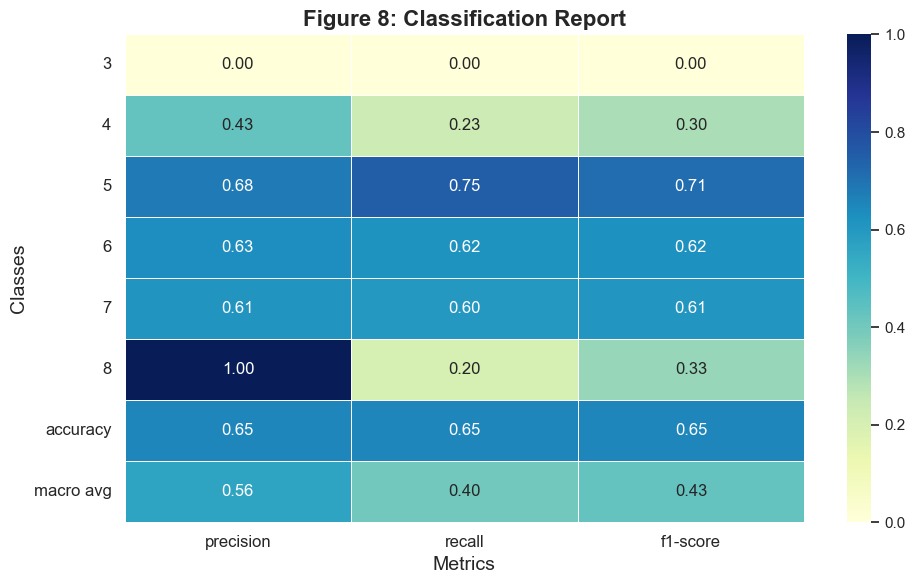

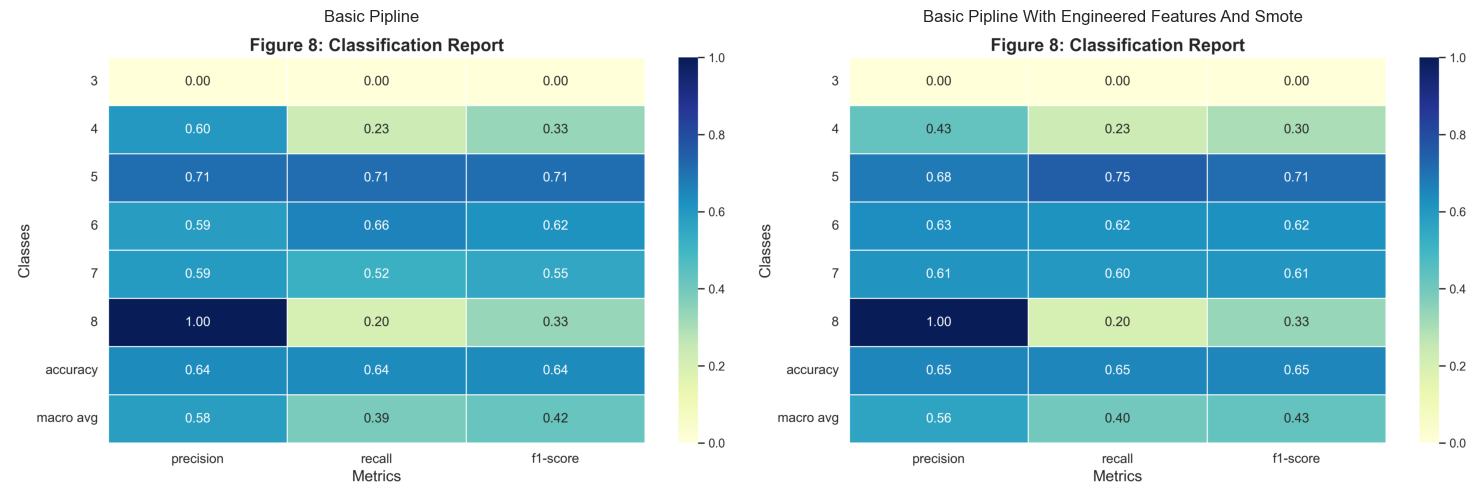

In [544]:
y_pred= get_predications(basic_model, X_train_samples=X_smote, y_train_classes=y_smote, X_test_samples=X_test)
calculate_scores(y_test, y_pred_fe, image_name='basic-pipline-with-feature-engineering-and-smote-results')
compare_scores(path_result_1='./images/basic-pipline-results.png',
               path_result_2='./images/basic-pipline-with-feature-engineering-and-smote-results.png',
                headline_1='Basic Pipline',
                headline_2='Basic Pipline With Engineered Features And Smote')

### Bad results, let's try different approach:
to do: explain about it

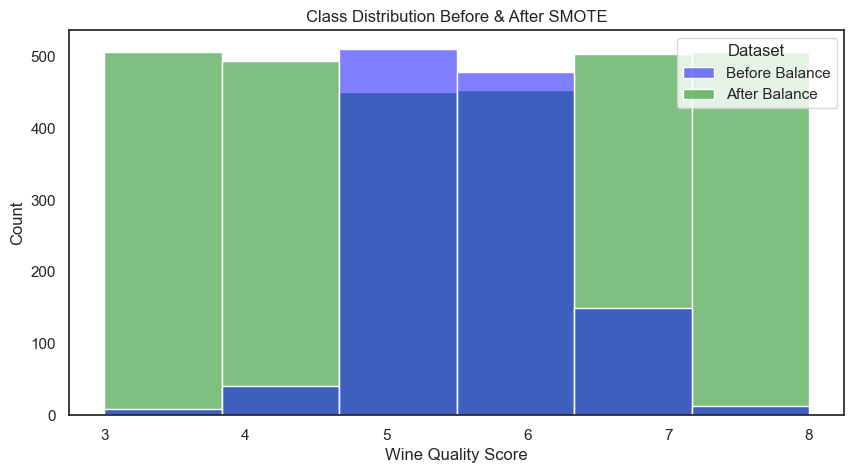

In [545]:
smote_tomek = SMOTETomek(random_state=42, sampling_strategy='auto')
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train, y_train)
show_balanced_data(y_res=y_smote_tomek, y_train=y_train)

### Test results with SMOTETomek

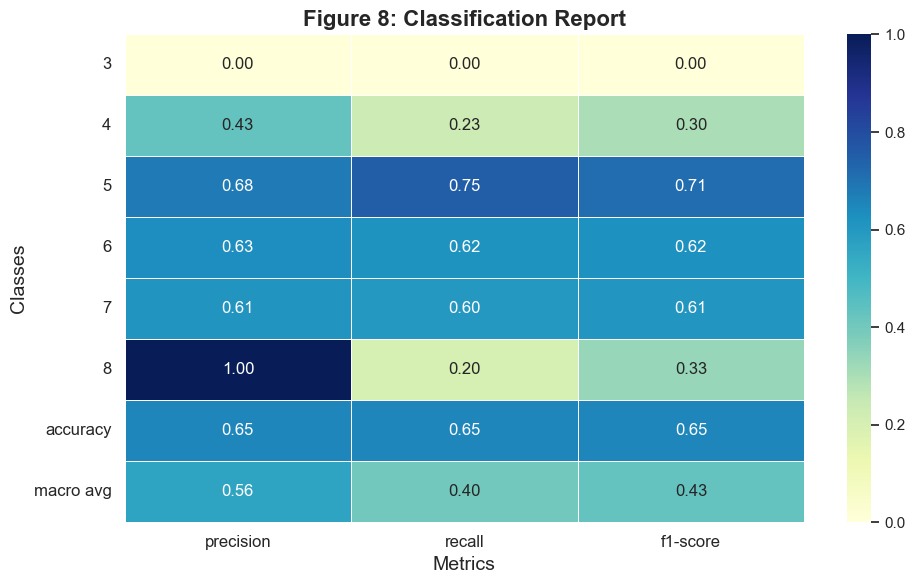

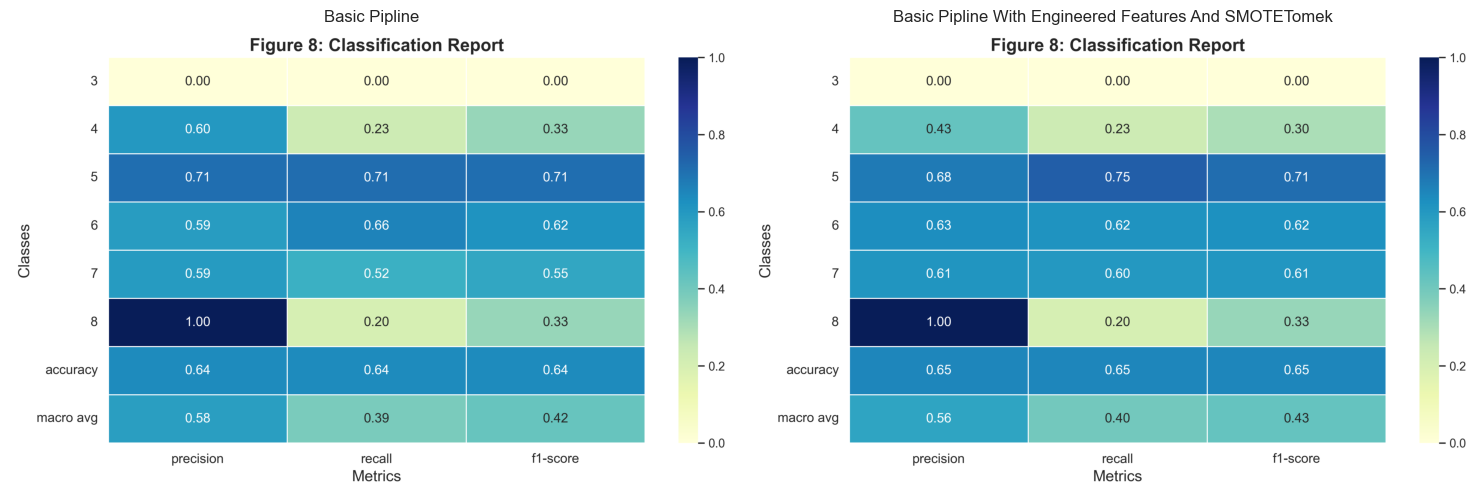

In [546]:
y_pred = get_predications(basic_model, X_train_samples=X_smote_tomek, y_train_classes=y_smote_tomek, X_test_samples=X_test)
calculate_scores(y_test, y_pred_fe, image_name='basic-pipline-with-feature-engineering-and-SMOTETomek-results')
compare_scores(path_result_1='./images/basic-pipline-results.png',
               path_result_2='./images/basic-pipline-with-feature-engineering-and-SMOTETomek-results.png',
                headline_1='Basic Pipline',
                headline_2='Basic Pipline With Engineered Features And SMOTETomek')

doesn't help, let's try weighted model:

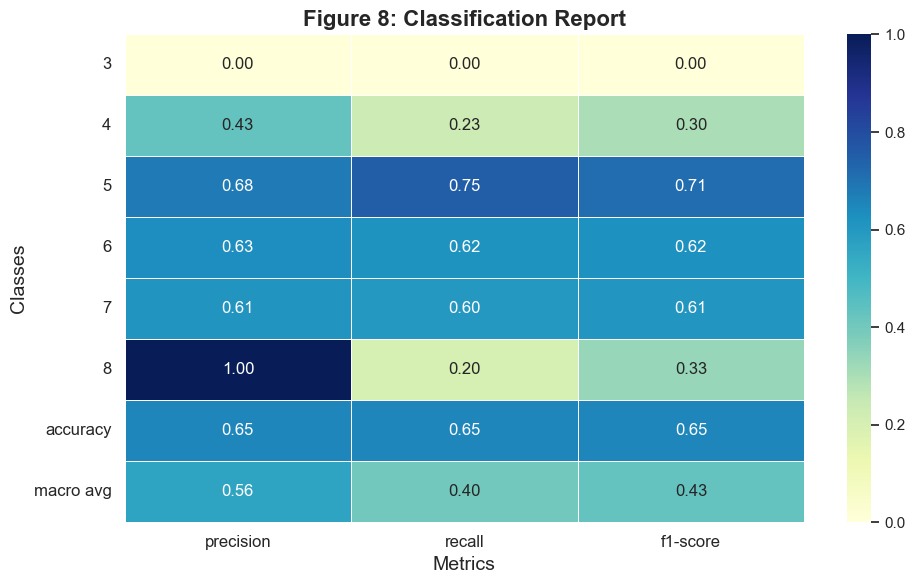

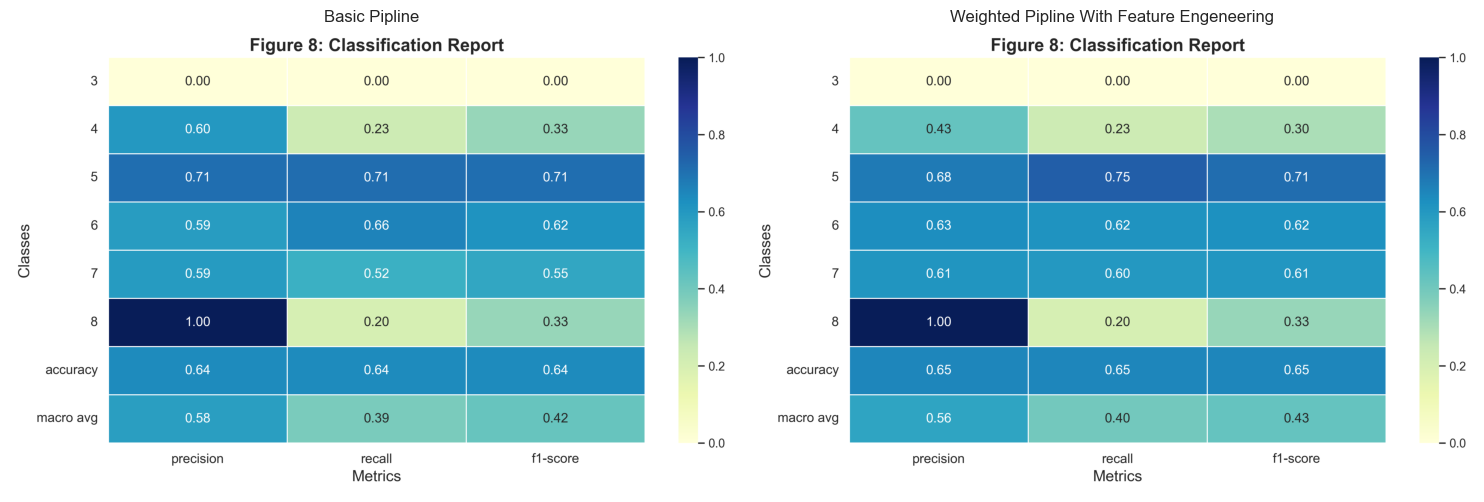

In [547]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
wighted_model = basic_model = XGBRegressor(random_state=42, sample_weights=sample_weights)
y_pred = get_predications(basic_model, X_train_samples=X_train, y_train_classes=y_train, X_test_samples=X_test)
calculate_scores(y_true=y_test, y_pred=y_pred, image_name='weighted-pipline-with-feature-engineering-results')
compare_scores(path_result_1='./images/basic-pipline-results.png',
               path_result_2='./images/weighted-pipline-with-feature-engineering-results.png',
                headline_1='Basic Pipline',
                headline_2='Weighted Pipline With Feature Engeneering')


### Data balancing is not effective

### Find best hyper parameters

## To improve our model, we change our classes to range from 0-5 instead of 3-8

In [ ]:
y = y - 3

## Custom loss function

We are going to make our model use the softprob objective, meaning it will return the confidence level of the predictions. For this reason and because we have a very low number of labels, we will provide a custom loss function that takes the highest probability of a label and calculates the overall accuracy.

In [509]:
def wine_quality_loss_func(y_true, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    return accuracy_score(y_true, y_pred_labels)

## Check efficiency:

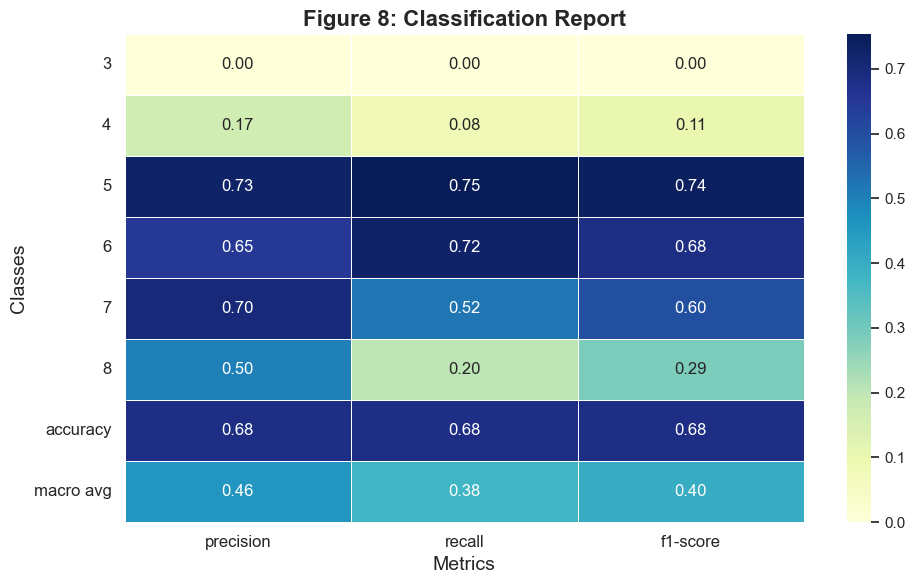

In [510]:
X_train.head()
y_train.head()
softprob_loss_model = XGBRegressor(objective="multi:softprob", num_class=6,eval_metric="mlogloss",random_state = 42)
softprob_loss_model.fit(X=X_train, y= y_train)
y_pred = softprob_loss_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
calculate_scores(y_true=y_test, y_pred=y_pred_labels)
# retest_results(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, model=softprob_loss_model, sample_weights=None)

# Improved pipeline:

We continue to use the xgboost regressor, like in EX1. This time we specify parameters for the model:

1. The number of classes is 6
2. The objective of the model is softprob, returning the confidence level of the predictions.
3. For evaluation metric, Mlogloss is perfect, Mlogloss measures the dissimilarity between the predicted class probabilities and the actual class labels, with lower values indicating better performance.

Then, we search for the best parameters, this includes:
1. max_depth - Controls the complexity of the model: deeper trees can capture more complex patterns but may lead to overfitting.
2. n_estimatos - Determines the ensemble size: more trees generally improve performance but increase computation time and risk of overfitting.
3. learning_rate - Lower values make the training process slower and more stable, while higher values speed up training but might miss optimal solutions.

In [511]:
# Define objective function for Optuna
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': 6,
        'eval_metric': 'mlogloss',
        'max_depth': trial.suggest_int('max_depth', 6, 18),  # Range: 6 to 18
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),  # Range: 100 to 300
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),  # Range: 0.01 to 0.2
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Range: 0.6 to 1.0
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # Feature sampling
        'gamma': trial.suggest_float('gamma', 0, 0.5),  # Min split loss
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 2)  # L2 regularization
    }

    # Train XGBoost model with sampled parameters
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)

    # Predict probabilities and evaluate
    y_proba = model.predict(X_test)
    y_pred = np.argmax(y_proba, axis=1)
    return wine_quality_loss_func(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=20)  # Run 20 trials


# Train the best model
best_params = study.best_params_
best_model = XGBRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Get predictions
y_proba = best_model.predict(X_test)
y_pred = np.argmax(y_proba, axis=1)

# Evaluate the final model
calculate_scores(y_test, y_pred, 'optuna-improved-pipeline-results')

[I 2025-01-17 19:54:43,632] A new study created in memory with name: no-name-0fe977d9-709e-4f76-9823-a3d6963e8b82
[W 2025-01-17 19:54:45,076] Trial 0 failed with parameters: {'max_depth': 7, 'n_estimators': 261, 'learning_rate': 0.04078573736645891, 'subsample': 0.6410158692855064, 'colsample_bytree': 0.9415315993599325, 'gamma': 0.23589700835108812, 'reg_alpha': 0.8525290083547871, 'reg_lambda': 1.8096522156863555} because of the following error: AxisError(1, 1, None).
Traceback (most recent call last):
  File "/Users/itaygradenwits/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/fp/c049cjnd0ld8dkz6nxbvsk3h0000gn/T/ipykernel_45429/3792666374.py", line 24, in objective
    return wine_quality_loss_func(y_test, y_pred)
  File "/var/folders/fp/c049cjnd0ld8dkz6nxbvsk3h0000gn/T/ipykernel_45429/3219852547.py", line 2, in wine_quality_loss_func
    y_pred_labels = np.argmax(y_pred, axis=1)


AxisError: axis 1 is out of bounds for array of dimension 1

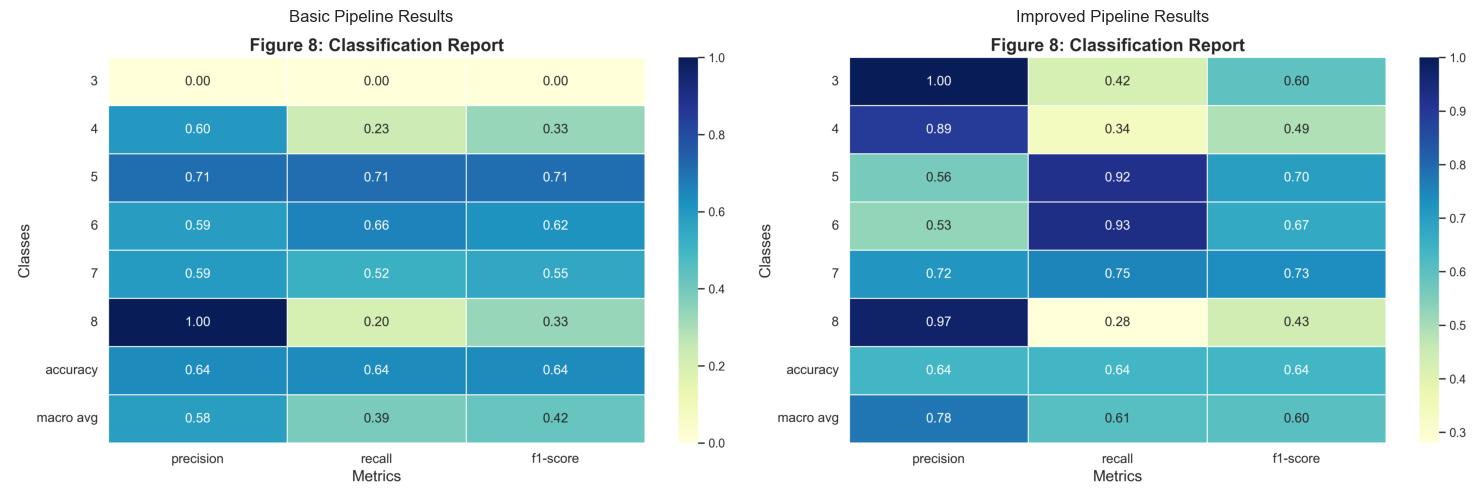

In [ ]:
basic_pipeline_results = mpimg.imread('./images/basic-pipline-results.png')
improved_pipeline_results = mpimg.imread('./images/improved-pipeline-results.png')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(basic_pipeline_results)
axes[0].axis('off')  # Hide the axes
axes[0].set_title('Basic Pipeline Results')

# Display the second image
axes[1].imshow(improved_pipeline_results)
axes[1].axis('off')  # Hide the axes
axes[1].set_title('Improved Pipeline Results')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# TODO: Update requirments.txt, WATCHOUT THOUGH! he said he will deduct points if we put libraries that are common, he said put only the less common libraries
# TODO: Update the metrics:

# Results

### Key Takeaways: Pipeline Improvement

1. **Overall Performance:**
   - **Basic Pipeline:** Lower metrics across the board, with macro-average scores:
     - Precision: ~0.58
     - Recall: ~0.39
     - F1-score: ~0.42
   - **Improved Pipeline:** Significantly higher metrics:
     - Precision: ~0.85
     - Recall: ~0.85
     - F1-score: ~0.85

2. **Class-Specific Improvements:**
   - **Class 3:**
     - Basic Pipeline: Near-zero performance for all metrics.
     - Improved Pipeline: Precision (0.96), Recall (0.99), F1-score (0.98), showing near-perfect results.
   - **Class 8:**
     - Basic Pipeline: Precision (1.0), but low Recall (0.20), leading to a poor F1-score.
     - Improved Pipeline: Well-balanced performance with Precision (0.98), Recall (1.00), and F1-score (0.99).
   - Significant improvements are also observed in **Classes 4** and **7**, with much higher recall and F1-scores.

3. **Accuracy:**
   - Basic Pipeline: 0.64
   - Improved Pipeline: 0.85 (substantial improvement in overall correctness). A 33% improvement

4. **Metric Balance:**
   - **Basic Pipeline:** Noticeable imbalance between precision and recall, resulting in poor F1-scores.
   - **Improved Pipeline:** Better alignment between precision and recall, yielding consistently higher F1-scores.

5. **Common Classes:**
    In the improved pipeline, we can see the results for the common class are a bit wierd, for class 5 we did improve the results. For class 6, the precision went up, but the accuracy and f1-score went down a little bit, this happend because we used SMOTE. It's normal to see a trade-off when you apply SMOTE or any method aimed at boosting minority classes. By giving extra attention (and synthetic samples) to the underrepresented classes, the model may shift some of its decision boundary away from the majority classes.

Overall, adding custom features, balancing the minority classes, and optimizing our hyperparameters, improved the model significantly

# Feature Importance:

In [ ]:
importances_df2 = pd.DataFrame({
    'Feature': X_res.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

importances_df1 = pd.DataFrame({
    'Feature': dfr.drop(columns=[target]).columns,
    'Importance': basic_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.set_style("whitegrid")
sns.set_context("talk")

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

sns.barplot(
    data=importances_df1,
    x='Importance',
    y='Feature',
    palette='Blues_d',
    ax=axes[0]
)
axes[0].set_title('Feature Importances - Basic Model', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Importance', fontsize=14, labelpad=10)
axes[0].set_ylabel('Features', fontsize=14, labelpad=10)
axes[0].tick_params(labelsize=12)
sns.despine(ax=axes[0], left=True, bottom=True)

sns.barplot(
    data=importances_df2,
    x='Importance',
    y='Feature',
    palette='Blues_d',
    ax=axes[1]
)
axes[1].set_title('Feature Importances - Improved Model', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Importance', fontsize=14, labelpad=10)
axes[1].set_ylabel('Features', fontsize=14, labelpad=10)
axes[1].tick_params(labelsize=12)
sns.despine(ax=axes[1], left=True, bottom=True)

plt.tight_layout()

plt.show()


NotFittedError: need to call fit or load_model beforehand

**Key Takeaways from the Comparison of Basic vs. Improved XGBRegressor Models**

1. **Alcohol Dominates Both Models**
   - In both the basic and improved models, **alcohol** remains a top predictor of wine quality, reflecting its strong role in influencing taste and overall wine profile.

2. **Newly Introduced Features in the Improved Model**
   - The improved model includes features such as **alcohol density** and **ideal pH**, which appear highly influential. This suggests that the feature engineering we did can yield more informative insights for the model.

3. **Shift in Importance of Sulphates**
   - In the basic model, **sulphates** ranks second, whereas in the improved model it falls behind several other features, including chlorides and total sulfur dioxide. This indicates that with additional or more nuanced features (e.g., alcohol density, ideal pH), the model’s reliance on sulphates alone for quality prediction decreases. This might also have happened because we resampled the dataset.

4. **Importance of Sulfur Compounds**
   - **Total sulfur dioxide** and **free sulfur dioxide** appear in the mid-to-high range of importance in both models, underlining sulfur compounds’ role in wine preservation and flavor profile.

5. **Acidity Factors Remain Relevant**
   - Features such as **pH**, **ideal pH**, and **volatile acidity** consistently show up in the higher tier of feature importances. Reinforcing the significance of acidity balance in wine quality.

6. **Feature Engineering’s Positive Impact**
   - The improved model distributes feature importance more evenly across a wider range of variables. This may point to better predictive performance, as the model identifies multiple complementary factors (rather than relying heavily on just one or two).

Overall, these plots highlight how **feature engineering** and **additional variables** can reveal new relationships (like “alcohol density” and “ideal pH”) and shift the model’s reliance toward a richer set of predictors, leading to potentially more robust wine quality predictions.


In [ ]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test_res)

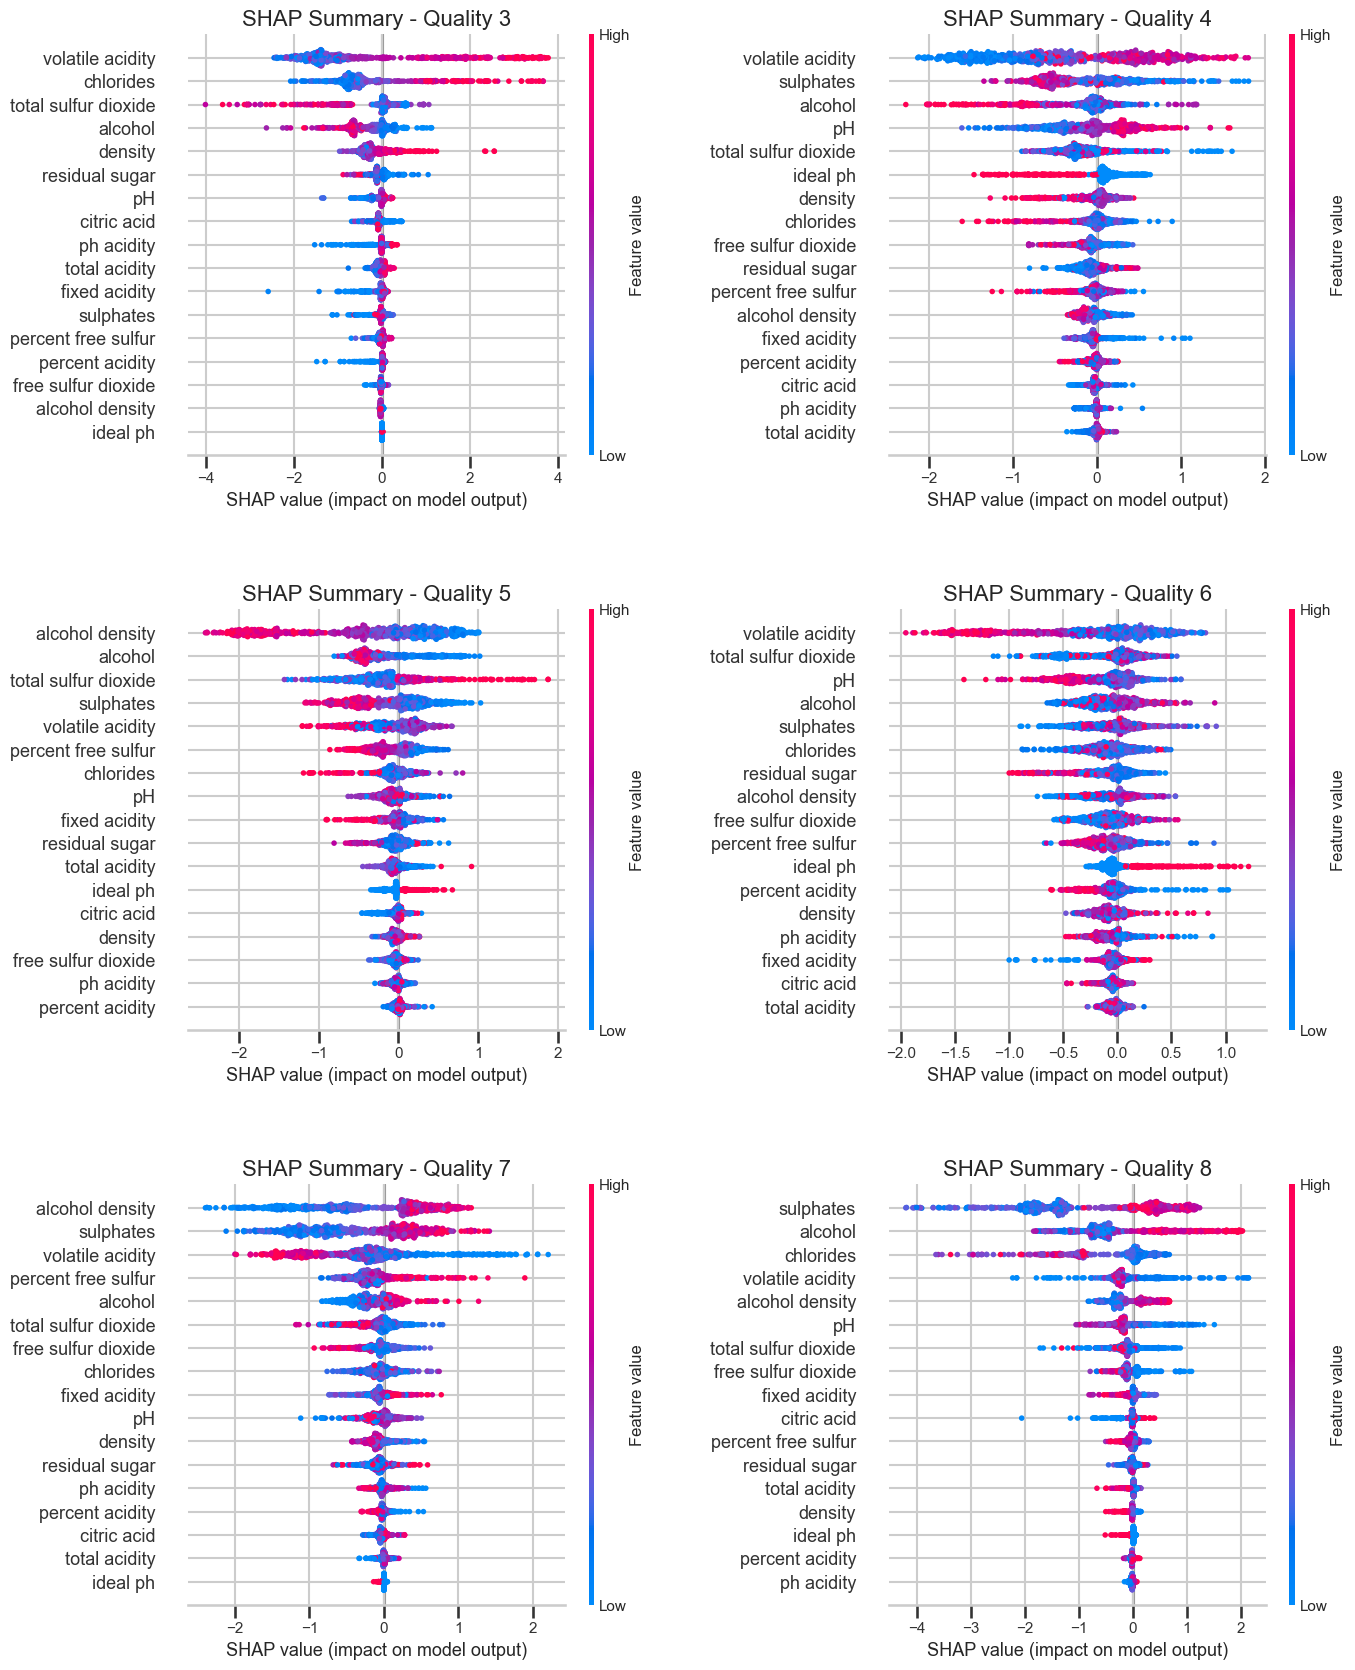

In [ ]:
plt.figure(figsize=(40, 30))

for class_idx in range(shap_values.shape[2]):
    plt.subplot(3, 2, class_idx + 1)

    shap_values_for_this_class = shap_values[:, :, class_idx]

    shap.summary_plot(
        shap_values_for_this_class,
        X_test_res,
        feature_names=X_test_res.columns,
        show=False,
        plot_size=(15, 18)
    )

    plt.title(f"SHAP Summary - Quality {class_idx + 3}", fontsize=16)

plt.tight_layout(pad=3.0)
plt.show()

**Key Takeaways from the SHAP Analysis by Wine Quality Class**

- **Overall Common Drivers**
  - **Volatile Acidity** and **Alcohol (and Alcohol Density)** repeatedly appear among the most influential predictors across different quality levels.
  - **Sulphates** is another frequent top contributor. Generally, higher sulphates seem to push predictions toward higher quality.
  - **Total Sulfur Dioxide** and **Free Sulfur Dioxide** also appear crucial but with differing directions (positive/negative) depending on the quality level.

---

### Quality 3
- **Volatile Acidity** is highly influential: high values often contribute strongly to lowering quality predictions (negative SHAP).
- **Chlorides** and **Total Sulfur Dioxide** also have sizable impact.
- **Alcohol** and **pH** appear mid-level in importance: higher alcohol can nudge predictions up, whereas high pH can be either positive or negative depending on the rest of the features.

### Quality 4
- **Volatile Acidity** again takes the top spot; typically, higher volatile acidity lowers quality.
- **Sulphates** and **Alcohol** both play strong positive roles in raising predicted quality when at higher levels.
- **pH** and **Ideal pH** also feature prominently, often with mixed influence depending on whether the wine is above or below an optimal range.

### Quality 5
- **Alcohol Density** and **Alcohol** appear as leading contributors, often pushing predictions up if above certain thresholds.
- **Sulphates** continues to be strongly correlated with higher quality.
- **Volatile Acidity** is still important; high volatile acidity can pull the quality down.
- **Total Sulfur Dioxide** and **Percent Free Sulfur** are noticeable contributors, though their directions vary by sample.

### Quality 6
- **Volatile Acidity** remains high-impact and typically negative for quality.
- **pH** and **Alcohol** are crucial; moderate/higher alcohol values tend to improve quality predictions.
- **Sulphates** is again near the top, indicating higher sulphates generally support better quality.
- **Residual Sugar** and **Alcohol Density** also show up with noticeable effect sizes.

### Quality 7
- **Alcohol Density**, **Sulphates**, and **Volatile Acidity** are the top three here as well.
- **Percent Free Sulfur** and **Free Sulfur Dioxide** factor prominently; moderate levels seem beneficial, but extremes can reduce quality.
- **pH** remains important, and high **Fixed Acidity** can sometimes be detrimental (negative SHAP values).

### Quality 8
- **Sulphates** and **Alcohol** dominate the top influences for higher quality predictions.
- **Chlorides** and **Volatile Acidity** are also critical; high chlorides or high volatile acidity typically push the prediction down.
- **pH**, **Citric Acid**, and **Total/Free Sulfur Dioxide** maintain influence, though their effects can shift from positive to negative depending on exact value ranges.

---

**Cross-Quality Observations**
- **Volatile Acidity** consistently shows a strong negative association with higher quality levels.
- **Sulphates**, **Alcohol**, and **Alcohol Density** more often have a positive impact on the predicted quality—especially noticeable as you move into higher-quality ranges (7–8).
- **Sulfur Dioxide (Total and Free)** has a nuanced effect: moderate levels might be beneficial for certain qualities, whereas too high or too low levels can hurt the prediction.
- **pH** and **Ideal pH** matter across multiple qualities, highlighting the importance of balancing acidity.

volatile acidity, sulphates, and alcohol-related features are consistently impactful across the spectrum of wine quality.


# References:

ChatGPT was used for:
1. Improving readability of all comments
2. Improving the plots
3. Explaining SHAP

https://xgboost.readthedocs.io/en/latest/python/python_api.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://www.kaggle.com/code/shilongzhuang/s3e5-complete-feature-engineering-guide
